In [516]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cd /Users/mehdi/Documents/WorkingFolder/PHd/weight_vector_simulations_paper/weight_vector_estim_code/

/Users/mehdi/Dropbox/working folder/PHd/weight_vector_simulations_paper/weight_vector_estim_code


In [3]:
from algorithm import WeightEstimator

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import multivariate_normal

In [15]:
n_samples = 100

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]


In [16]:
densities =[]
for x in np.linspace(-10,10,20):
    for y in np.linspace(-10,10,20):
        for var in [5, 1, 1e-1]:
            densities.append(multivariate_normal([x,y], var*np.diag([1,1])))

In [13]:
%matplotlib inline

NameError: name 'res' is not defined

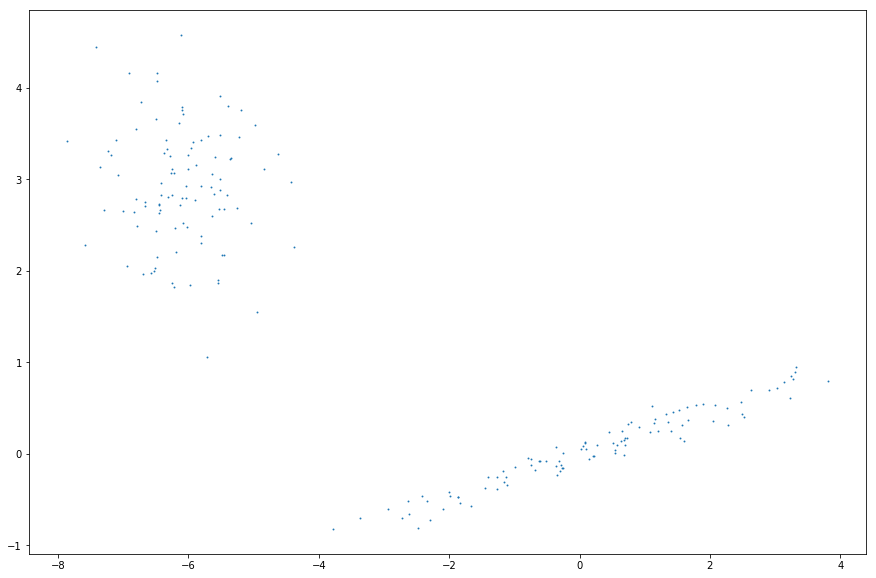

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
splot = plt.subplot(1, 1, 1)

splot.scatter(X[:,0],X[:,1], .8)
for i,_ in res:
    d = densities[i]
    mean, covar = d.mean, d.cov
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [12]:
gmm = GaussianMixture(20)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=20, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [13]:
densities =[]
for mean, var in zip(gmm.means_, gmm.covariances_):
    densities.append(multivariate_normal(mean, var))

In [8]:
cl = WeightEstimator(densities_dict=densities, select_threshold=1e-3)
cl.fit(X)


[ 0.  0.  0. ...,  0.  0.  0.]


In [10]:
cl.pi_final[cl.pi_final > 0]

array([ 0.00315446,  0.08360719,  0.00423585,  0.03617514,  0.15839016,
        0.14192934,  0.07263215,  0.00818737,  0.04433308,  0.06530192,
        0.09671991,  0.12418801,  0.08540385,  0.05481422,  0.02092736])

In [14]:
#On va essayer de faire une grille de l'espace et faire tourner EM et kde sur chaque portion
#pour construire le dictionaire


In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X0 = sc.fit_transform(X)

In [16]:
k_em = 2
x_min, x_max, y_min, y_max = X0[:,0].min(), X0[:,0].max(), X0[:,1].min(), X0[:,1].max()
x_steps = np.linspace(x_min, x_max, grid_length)
y_steps = np.linspace(y_min, y_max, grid_length)
densities_dictionary = []
for grid_length in [5]:
    for idx, x_step in enumerate(x_steps[:-1]):
        for idy, y_step in enumerate(y_steps[:-1]):
            X_temp = X0[(X0[:,0] > x_step) & (X0[:,0] < x_steps[idx+1]) & (X0[:,1] > y_step) & (X0[:,1] < y_steps[idy+1]) ]
            if X_temp.shape[0] > k_em:
                gmm = GaussianMixture(3)
                gmm.fit(X_temp)
                for mean, var in zip(gmm.means_, gmm.covariances_):
                    densities_dictionary.append(multivariate_normal(mean, var))

NameError: name 'grid_length' is not defined

In [ ]:
cl = WeightEstimator(densities_dict=densities_dictionary, select_threshold=1e-10)

In [ ]:
cl.fit(X)

In [ ]:
res = cl.select_densities()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
splot = plt.subplot(1, 1, 1)

splot.scatter(X0[:,0],X0[:,1], .8)
for i,_ in res:
    d = densities_dictionary[i]
    mean, covar = d.mean, d.cov
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [ ]:
best_bic = 1e10
for k in range(2,50):
    gmm = GaussianMixture(k)
    gmm.fit(X0)
    bic = gmm.bic(X0)
    if bic < best_bic:
        best_bic = bic
        score = gmm.score(X0)
        print score
        best_bic_param = (bic, score, gmm.covariances_, gmm.means_, gmm.weights_)
    

In [ ]:
best_bic_param

In [ ]:
densities_em = []
for cov, mean in zip(best_bic_param[2], best_bic_param[3]):
    densities_em.append(multivariate_normal(mean, cov))


In [ ]:
X, Y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
X_grid = np.vstack([X.ravel(), Y.ravel()]).T
X_grid

In [ ]:
def f(x):
    fk = np.array([d.pdf(x) for d in densities_em])
    return best_bic_param[-1].dot(fk)
f_em = np.apply_along_axis(f, 1, X0)
print np.log(f_em).sum()/X0.shape[0]

In [48]:
selected_densities_estim, weights_estim = np.array(zip(*res2))
f_weight_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 1, X0)
log_lik = np.log(f_weight_estim).sum()/X0.shape[0]
log_lik

-54.882235678734169

In [17]:
res

[(218, 0.06889282692661267),
 (221, 0.035466544430183496),
 (277, 0.10231750989867713),
 (278, 0.1456275319223059),
 (281, 0.10825819703086038),
 (338, 0.01906926295800231),
 (449, 0.04082022119365628),
 (509, 0.07447416210326328),
 (569, 0.126301475765866),
 (632, 0.1256061852841631),
 (692, 0.06665509095610522),
 (752, 0.037483876841484486),
 (812, 0.01421875846189462)]

In [17]:
from algorithm import WeightEstimator
cl = WeightEstimator(densities_dict=densities, select_threshold=1e-2)
cl.fit(X)
a = cl.pi_final

In [18]:
cd ../weight_vector_simulations_paper/weight_vector_estim_code/

[Errno 2] No such file or directory: '../weight_vector_simulations_paper/weight_vector_estim_code/'
/Users/mehdi/Dropbox/working folder/PHd/weight_vector_simulations_paper/weight_vector_estim_code


In [19]:
F = np.array([densities[i].pdf(X) for i in range(len(densities))]).T

In [20]:
def f0(pi,F):
    return -np.log((pi*F).sum(axis=1)).sum()

In [26]:
from sklearn.mixture import GaussianMixture
def mle_bic(X, kmax):
    best_bic = 1e10
    best_model = None
    for k in range(2,kmax):
        cl = GaussianMixture(n_components=k)
        cl.fit(X)
        bic = cl.bic(X)
        if bic < best_bic:
            best_bic = bic
            best_model = cl
    return best_bic, best_model

(956.66188635617254,
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=2, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None))

In [38]:
cd /Users/mehdi/Documents/WorkingFolder/PHd/phd-clustering-models/tools/

/Users/mehdi/Dropbox/working folder/PHd/phd-clustering-models/tools


In [41]:
from gm_tools import gaussian_mixture_sample, gm_params_generator, best_cont_matrix
weights, centers, cov = gm_params_generator(2,5)
X, Y = gaussian_mixture_sample(weights, centers, cov, 1000)

In [42]:
mle_bic(X,15)

(-3015.5472245981714,
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=5, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None))

In [47]:
cd /Users/mehdi/Documents/WorkingFolder/PHd/weight_vector_simulations_paper/weight_vector_estim_code/

/Users/mehdi/Dropbox/working folder/PHd/weight_vector_simulations_paper/weight_vector_estim_code


In [48]:
from DensitiesGenerator import DensityGenerator

In [49]:
dg = DensityGenerator(n_pdf= 1000)

In [58]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import laplace
from scipy.integrate import simps
nodes_gauss = [0, 0.2, 0.4, 0.6, 0.8, 1]
var_list = [1, 10**(-1), 10**(-2), 10**(-3)]
densities = []
for m in nodes_gauss:
    for var in var_list:
        densities.append(multivariate_normal(m, var))
scales =[0.05, 0.1, 0.2, 0.5, 1]
nodes_lapl = [0, 0.2, 0.4, 0.6, 0.8, 1]
for m in nodes_lapl:
    for scale in scales:
        densities.append(laplace(loc=m, scale=scale))
X = dg.generate_uniform(n_points=100)


In [63]:
Y = X[0].reshape(-1,1)

In [64]:
mle_bic(Y,15)

(47.474573931065919,
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=3, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None))

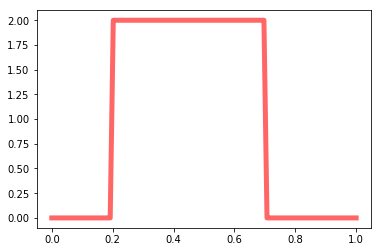

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import uniform
rv = uniform(0.2,0.5)
x = np.linspace(0,1, 100)
plt.plot(x, rv.pdf(x),'r-', lw=5, alpha=0.6, label='uniform pdf')

In [150]:
densities = []
for i in range(50):
        densities.append(uniform_nonzero(i*1./50,1./50))

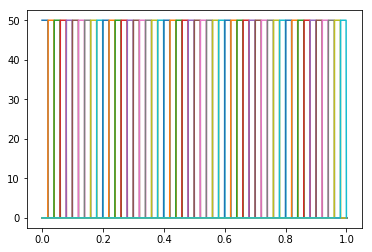

In [151]:
x = np.linspace(0, 1, 1000)
for d in densities:
    plt.plot(x, d.pdf(x))

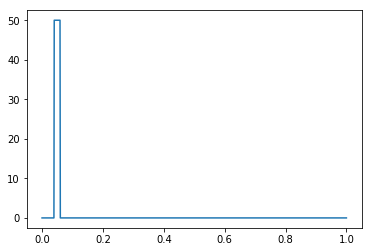

In [152]:
plt.plot(x, densities[2].pdf(x))

# Generation du dictionnaire

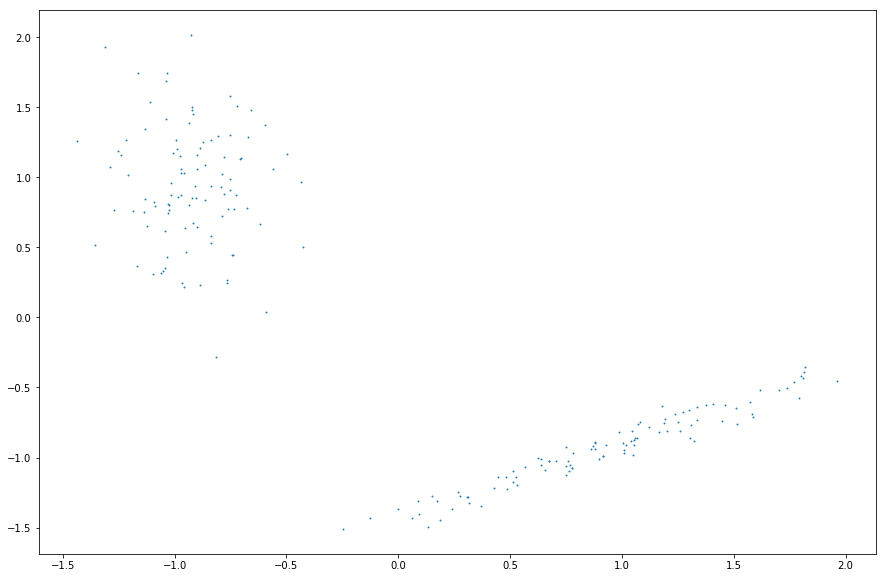

In [17]:
X = sc.fit_transform(X)
plt.scatter(X[:,0],X[:,1], .8)

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [19]:
pc = PCA(2)
sc = StandardScaler()

In [31]:
X_pca = pc.fit_transform(sc.fit_transform(X))
pc.components_

array([[-0.70710678,  0.70710678],
       [-0.70710678, -0.70710678]])

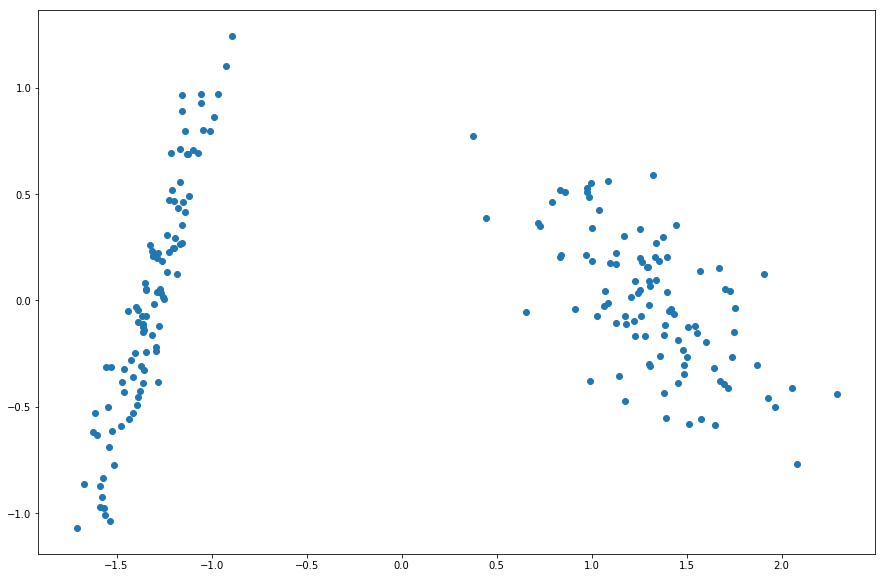

In [32]:
plt.scatter(X_pca[:,0], X_pca[:,1])

In [22]:
from sklearn.cluster import KMeans
km = KMeans(5)
X_temp0= km.fit_predict(X_pca[:,0].reshape(-1,1))
X_temp1= km.fit_predict(X_pca[:,1].reshape(-1,1))

In [23]:
X_temp1[0]

2

In [43]:
kmeans = KMeans(2)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
y = kmeans.labels_

In [51]:
y[np.where(y==1)]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [122]:
cd ../tools/

/Users/mehdi/Dropbox/working folder/PHd/phd-clustering-models/tools


In [159]:
from gm_tools import gaussian_mixture_sample, gm_params_generator, best_cont_matrix
weights, centers, cov = gm_params_generator(10,3)
X, Y = gaussian_mixture_sample(weights, centers, cov, 1000)

In [160]:
X

array([[ 0.03717608, -1.15220815, -0.63477926, ...,  1.30554143,
         2.22423824,  1.51622318],
       [-0.07206821, -0.91839595, -0.62778374, ...,  1.43750006,
         2.33168   ,  1.69296087],
       [ 1.47955317, -1.10682111, -2.62963366, ...,  0.3303743 ,
         2.13341828, -0.6861456 ],
       ..., 
       [-0.43803426, -1.28543693, -0.91326653, ...,  0.9660687 ,
         1.85596215,  1.45977998],
       [-0.43260847, -1.55075385, -0.80510266, ...,  1.07989485,
         1.7797362 ,  1.39173138],
       [-0.26803614, -1.35060715, -0.89429421, ...,  1.06051135,
         1.72468985,  1.45074475]])

In [167]:
dg = DictionaryGenerator(max_pca_comp=5)

In [168]:
dg.fit(X )
dg.densities

[[<scipy.stats._multivariate.multivariate_normal_frozen at 0x1146ec4d0>,

In [79]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(2)
gm.fit(X)
gm.covariances_

array([[[ 0.03863992, -0.0073086 ],
        [-0.0073086 ,  0.17751361]],

       [[ 0.25322626,  0.13426231],
        [ 0.13426231,  0.07563479]]])

In [173]:
import pypmc

In [181]:
from pypmc.sampler.importance_sampling import ImportanceSampler


In [175]:
for i in range(X.shape[1]):
    print X[:,i].min(), X[:,i].max()

-2.68449893153 1.9113202268
-1.88855044146 1.60213288427
-2.74197546065 -0.32963205798
-2.81993508036 2.55187166683
-2.01797346592 1.08148826271
-2.48619196342 0.0539009970857
-2.75843006585 0.557241085456
-2.48493987178 1.6740202351
1.29569806977 2.64557118809
-1.73689129564 1.95689548016


In [176]:
from pypmc.tools.indicator import merge_function_with_indicator

# define indicator
ind_lower = [-3 for _ in range(X.shape[1])]
ind_upper = [3 for _ in range(X.shape[1])]
ind = pypmc.tools.indicator.hyperrectangle(ind_lower, ind_upper)


In [298]:
from pypmc.density.mixture import create_gaussian_mixture



class Gaussian_mixture_gen(object):
    """
    Simple gaussian mixture class
    """
    def __init__(self, p, weights):
        self.K = len(weights)
        self.weights = weights
        self.centers = self.binary_centers(self.K, p)
        self.cov = np.array([1e-2*np.diag(np.ones(p)) for _ in range(self.K)])
        
    def binary_centers(self, K,p):
        if K > 2**p:
            print "Warning: not enough nodes"
            K_ = 2**p
        else:
            K_ = K
        centers = []
        for i in range(K_):
            bin_array = list(bin(i).split("b")[1])
            zeros_arr = [0]*(p-len(bin_array))
            centers.append(np.array(map(int, zeros_arr+bin_array)))
        return np.array(centers)
    
    def get_params(self):
        return self.centers, self.cov
    
    def sample(self, N):
        mixture = create_gaussian_mixture(self.centers, self.cov, self.weights)
        return mixture.propose(N)
        

In [187]:
y = np.ma.array([1, 2, 3], mask = [0, 1, 0])

masked_array(data = [1 -- 3],
             mask = [False  True False],
       fill_value = 999999)

In [238]:
np.diag(np.ones(5))

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [234]:
binary_centers(50,22)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [299]:
K = 10
N = 100
p = 5
weights = 1./K*np.ones(K)
gg = Gaussian_mixture_gen(p, weights)
X2 = sc.fit_transform(gg.sample(N))

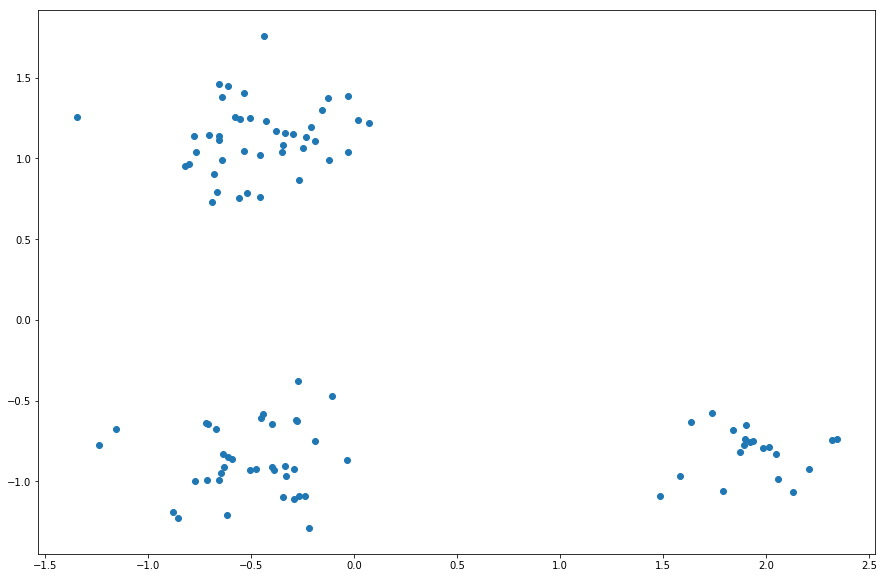

In [300]:
plt.scatter(X2[:,1], X2[:,2])

In [301]:
gg.get_params()

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 1],
        [0, 0, 1, 1, 0],
        [0, 0, 1, 1, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1]]), array([[[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.01,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.01,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.01,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01]],
 
        [[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.01,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.01,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.01,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01]],
 
        [[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.01,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.01,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.01,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01]],
 
        [[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ],
    

In [9]:
from tools import get_results
import pickle

In [8]:
folder = "/Users/mehdi/temp/simus weight vector/GLU_valid_2017-06-12_18.37.51/"
df = get_results(folder)

/usr/local/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


KeyboardInterrupt: 

In [11]:

a = pickle.load(open("/Users/mehdi/temp/simus weight vector/GLU_valid_2017-06-12_18.37.51/res_K0N100_00f94cec-513f-4268-9d05-57dedcbeea42"))

In [14]:
a['rect_mle_time',
 'rect_mle_bic_time',
 'uniform_kde']

KeyError: ('rect_mle_time', 'rect_mle_bic_time', 'uniform_kde')

# nouveaux clusters


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
%matplotlib inline

In [66]:
p = 3
cov = np.array([[1,0],[0,10]])

In [136]:
N=1000
means = [[0.1, 0.3], [0.3,0.7], [0.6, 0.1], [0.7,0.5]]
cov = 1e-3*np.array([
        np.array([[0.5, 0],
                [0, 8]]),
        np.array([[1, -1.5],
                [-1.5, 4]]),
        np.array([[6, 0],
                [0, 0.2]]),
        np.array([[5, 3],
                [3, 2]])
      ])
params = zip(means, cov)
X = np.zeros([4*N,2])
X[:N,:]=multivariate_normal(params[0][0], params[0][1]).rvs(N)
i=1
for m, c in params[1:]:
    X[i*N:(i+1)*N,:] = multivariate_normal(m, c).rvs(N)
    i+=1


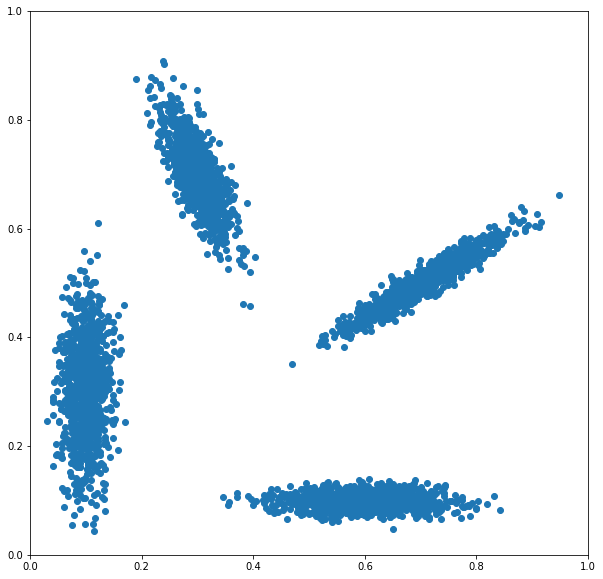

In [137]:
plt.figure(figsize=[10,10])
plt.xlim([0,1])
plt.ylim([0,1])

plt.scatter(X[:,0], X[:,1])

In [70]:
np.vstack([np.array([1,4]),np.array([2,4])])

array([[1, 4],
       [2, 4]])

In [135]:
X.shape

(1000, 2)

In [38]:
#Essai en dim p

# On genere les params et on selectionne si ca nous convient
p = 5
K = 2
N = 100
params = []
for _ in range(K):
    A = np.random.random([p, p])
    d = np.ones(p)
    d[np.random.randint(p)] = 10
    C = 1e-3*(np.diag(d)) #A.dot(A.T)
    v = np.random.random(p)
    m = v
    params.append((m, C))
X = np.zeros([4*N,p])
X[:N,:]=multivariate_normal(params[0][0], params[0][1]).rvs(N)
i=1
for m, c in params[1:]:
    X[i*N:(i+1)*N,:] = multivariate_normal(m, c).rvs(N)
    i+=1

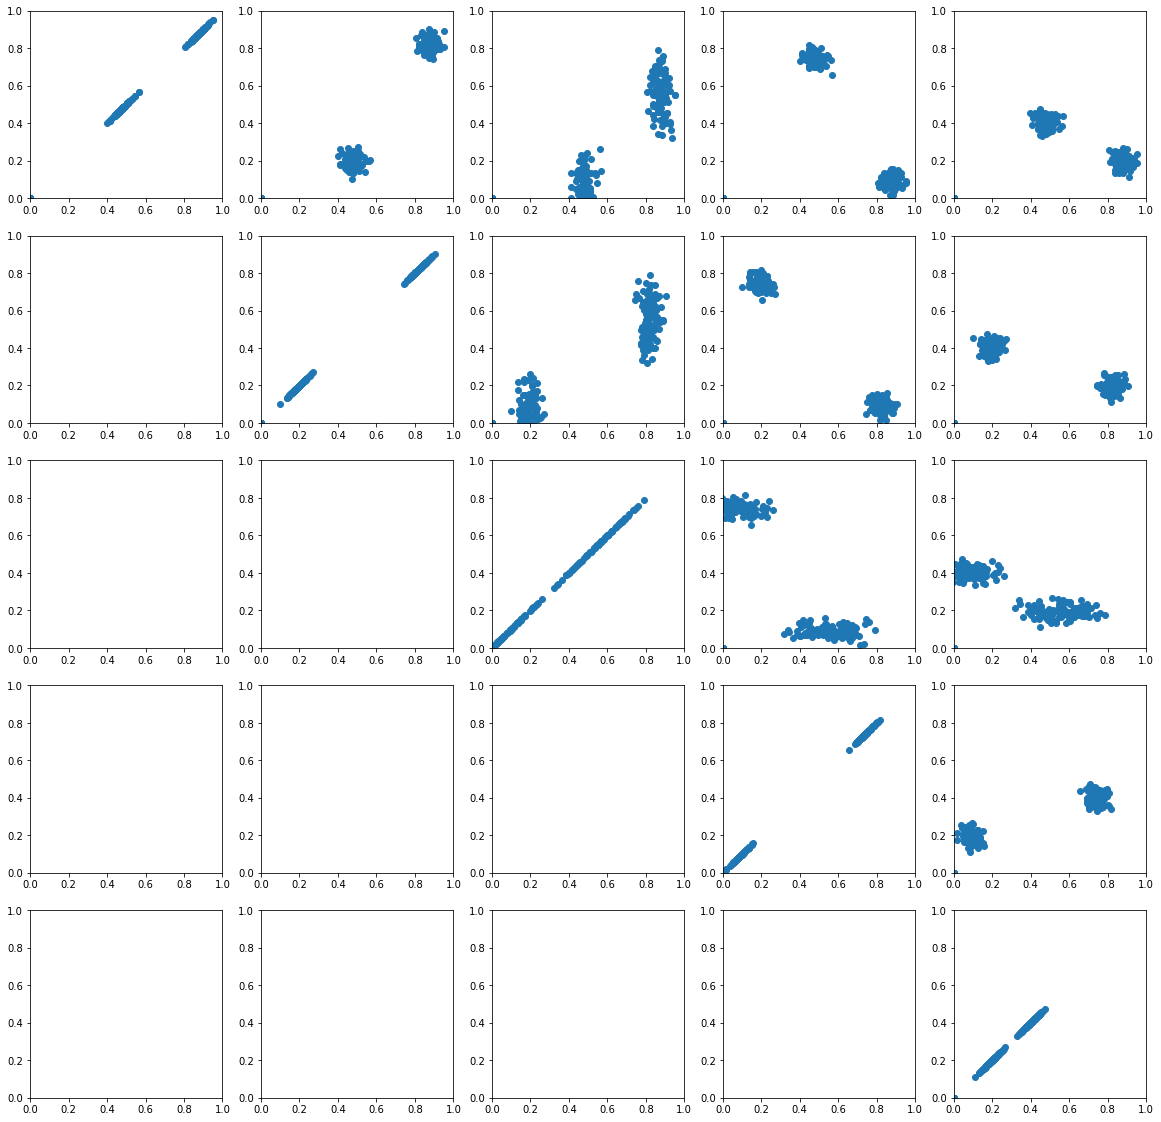

In [39]:
fig, ax = plt.subplots(5,5, figsize=(20,20))
for i in range(p):
    for j in range(i, p):
        ax[i][j].set_xlim([0,1])
        ax[i][j].set_ylim([0,1])        
        ax[i][j].scatter(X[:,i], X[:,j])

In [228]:
np.diag(np.random.normal(np.random.randint(5),1).,5,p))

array([[3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 0, 3, 0, 0],
       [0, 0, 0, 3, 0],
       [0, 0, 0, 0, 3]])

In [243]:
np.random.normal(np.random.randint(50),1,p)

array([ 40.7588952 ,  41.3955466 ,  41.06611134,  42.40520043,  41.77968484])

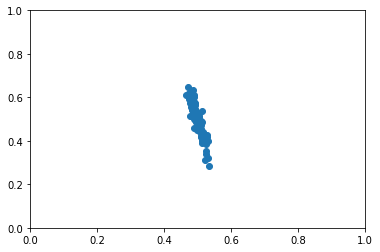

In [27]:
d = np.ones(p)
d[np.random.randint(p)] =5
np.diag(d)

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [108]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm


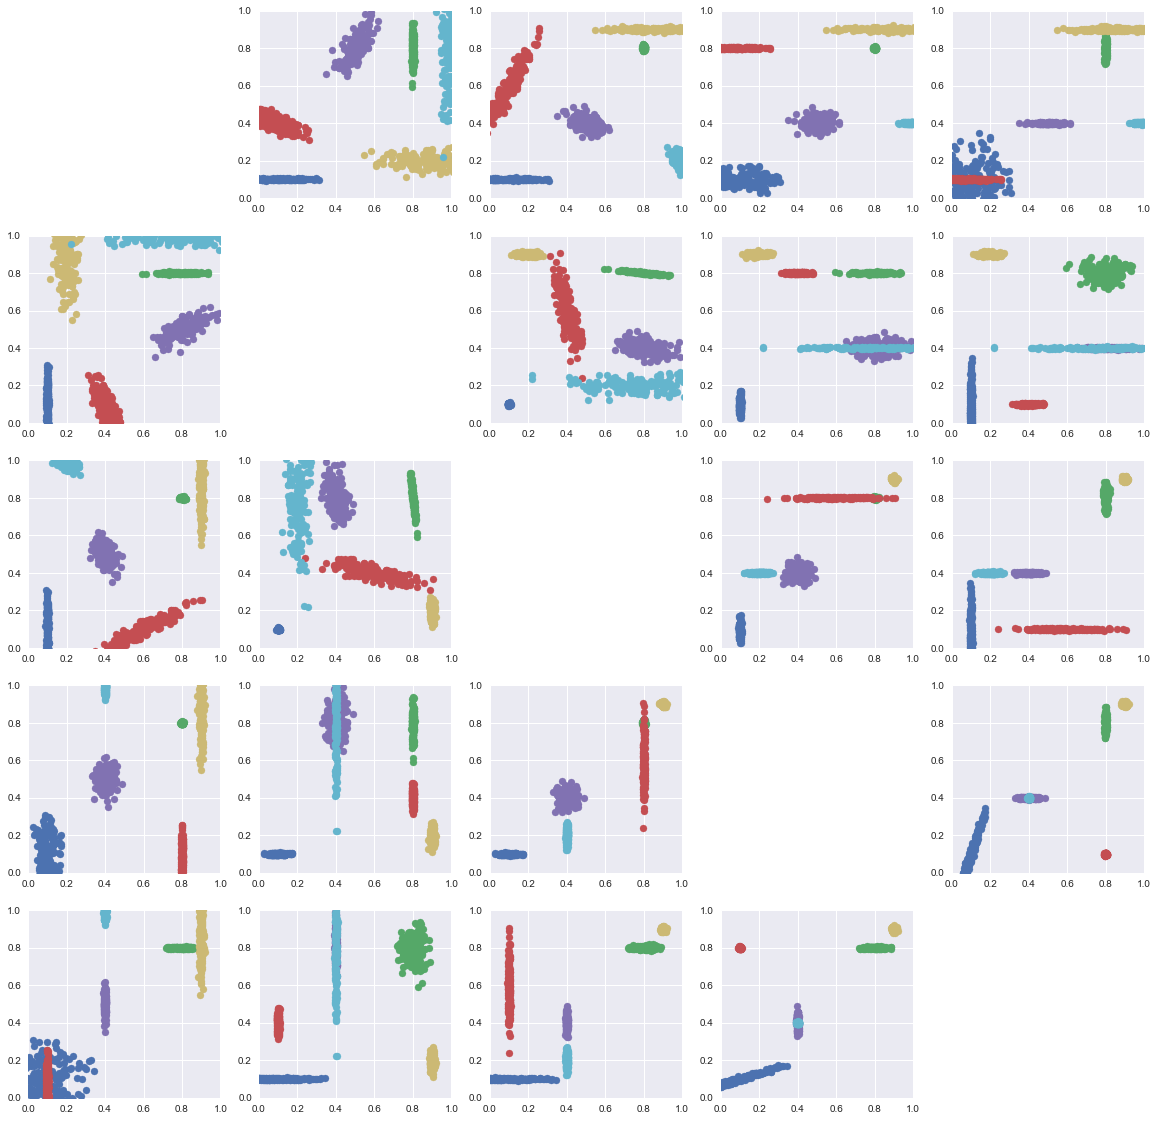

In [52]:
from scipy.stats import multivariate_normal
import numpy as np

class BasicGen(object):
    #dirty gross generator
    def __init__(self, dim=5):
        self.dim = dim
        self.params = [
            (np.array([[3, 0, 0, 0, 0],
                      [0, 0.1, 0, 0, 0],
                      [0, 0, 0.1, 0, 0],
                      [0, 0, 0, 0.1, 1],
                      [0, 0, 0, 1, 3]]), 
             np.array([0.1, 0.1, 0.1, 0.1, 0.1])), 
            (np.array([[0.1, 0, 0, 0, 0],
                            [0, 2, -0.2, 0, 0],
                            [0, -0.2, 0.1, 0, 0],
                            [0, 0, 0, 0.1, 0],
                            [0, 0, 0, 0, 1]]),
             np.array([0.8, 0.8, 0.8, 0.8, 0.8])), 
            (np.array([[1, 0.1, 1.9, 0, 0],
                       [0.1, 0.5, -1, 0, 0],
                       [1.9, -1, 3, 0, 0],
                       [0, 0, 0, 0.1, 0],
                       [0, 0, 0, 0, 0.1]]),
             np.array([0.1, 0.4, 0.6, 0.8, 0.1])),
            (np.array([[0.5, 1, -1, 0, 0],
                       [1, 2, 0, 0, 0],
                       [-1, 0, 0.1, 0, 0],
                       [0, 0, 0, 1, 0],
                       [0, 0, 0, 0, 0.1]]),
             np.array([0.5, 0.8, 0.4, 0.4, 0.4])),
            (np.array([[4, 0, 0, 0, 0],
                       [0, 1, 0, 0, 0],
                       [0, 0, 0.2, 0, 0],
                       [0, 0, 0, 0.2, 0],
                       [0, 0, 0, 0, 0.2]]),
             np.array([0.9, 0.2, 0.9, 0.9, 0.9])),
            (np.array([[0.1, 0, -1, 0, 0],
                       [0,  6, 0,   0, 0],
                       [-1, 0, 0.1, 0, 0],
                       [0, 0, 0, 0.1, 0],
                       [0, 0, 0, 0, 0.1]]),
             np.array([1, 0.8, 0.2, 0.4, 0.4]))
        ]
        self.change_dim(self.dim)
        self.means, self.variances = zip(*self.params)
    
    def change_dim(self, p):
        params = []
        for cov, m in self.params:
            C = cov[:p,:p]
            params.append((m[:p], 1e-3*C.T.dot(C)))
        self.params = params
    
    def get_params(self):
        return self.means, self.variances
    
    def sample(self, N, with_ids = False):
        #We generate a dataset with specific data
        K = len(self.params)
        X = multivariate_normal(self.params[0][0], self.params[0][1]).rvs(N/K)
        ids = np.ones(N/K)
        i = 2
        for m, cov in self.params[1:]:
            X = np.vstack([X, multivariate_normal(m, cov).rvs(N/K)])
            ids = np.hstack([ids, i*np.ones(N/K)])
            i+=1
        if with_ids:
            X = np.hstack([X, ids.reshape(-1,1)])
        np.random.shuffle(X)
        return X


#means, covas = gg.get_params()
p=5
gg = BasicGen(dim=p)
X_ = gg.sample(1000, with_ids=True)
ids = X_[:,-1]
X = X_[:,:-1]
fig, ax = plt.subplots(p,p, figsize=(20,20))
#cm = LinearSegmentedColormap.from_list(
#        cm.cmap_name, colors, N=n_bin)
for k in set(ids):
    for i in range(p):
        for j in range(p):
            if i!=j :
                ax[i][j].set_xlim([0,1])
                ax[i][j].set_ylim([0,1])        
                ax[i][j].scatter(X[ids==k][:,i], X[ids==k][:,j], cmap="cmap_name_r")
            else:
                ax[i][j].set_axis_off()

fig.savefig("../../phd-thesis/TeX_files/experiments_data",dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)


In [236]:
len(X)

96

NameError: name 'XA' is not defined

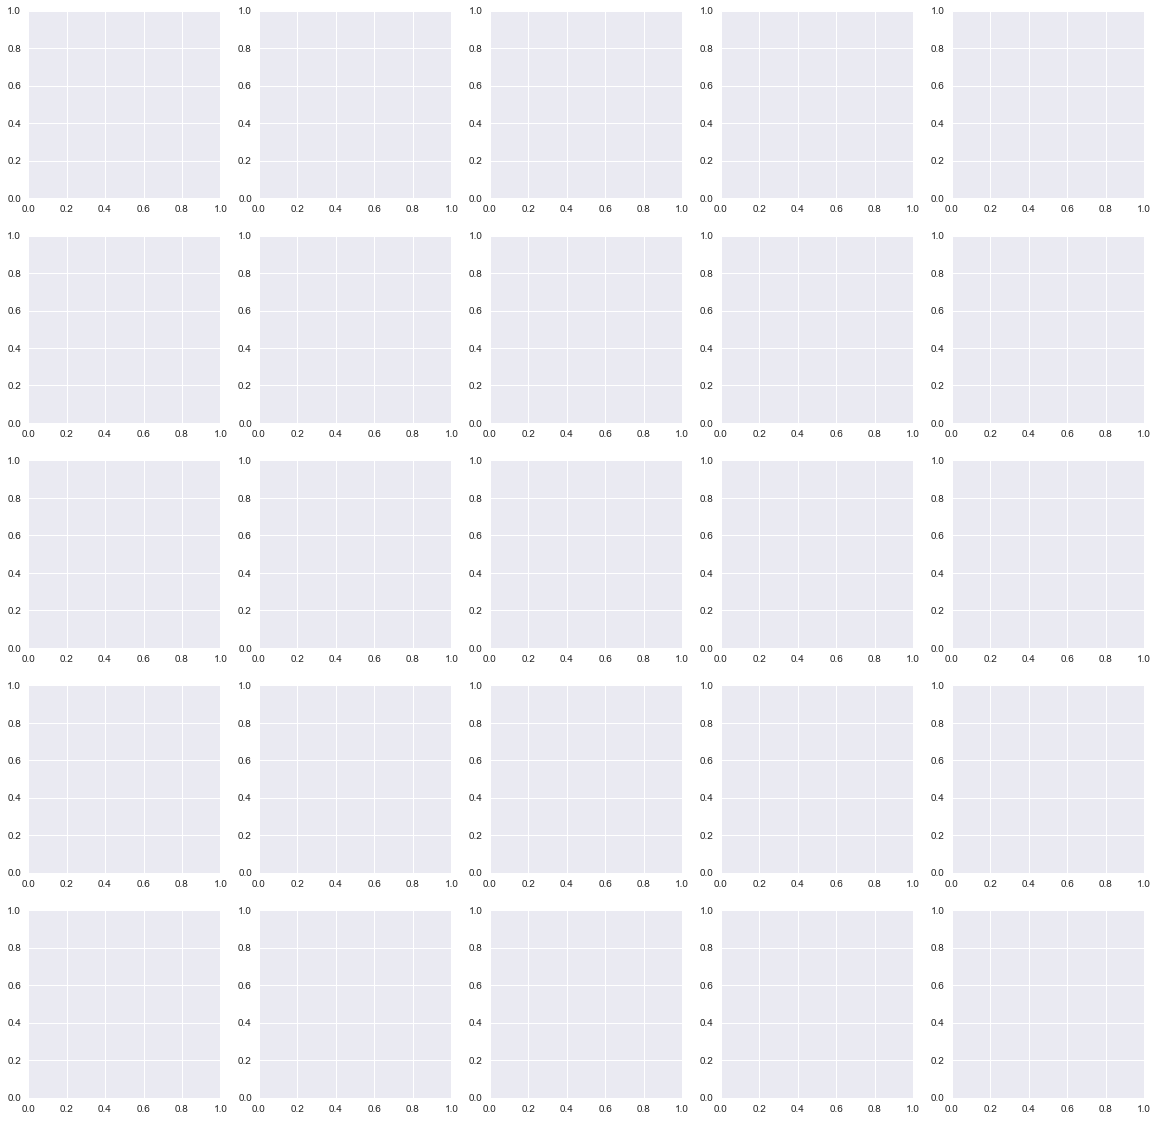

In [237]:


fig, ax = plt.subplots(p,p, figsize=(20,20))
for i in range(p):
    for j in range(i, p):
        ax[i][j].set_xlim([0,1])
        ax[i][j].set_ylim([0,1])        
        ax[i][j].scatter(XA[:,i], XA[:,j], color='r')
        ax[i][j].scatter(XB[:,i], XB[:,j], color='b')
        ax[i][j].scatter(XC[:,i], XC[:,j], color='g')
        ax[i][j].scatter(XD[:,i], XD[:,j], color='y')
fig.show()


In [195]:
E = np.diag([0.1,3,0.1,0.1,0.1])

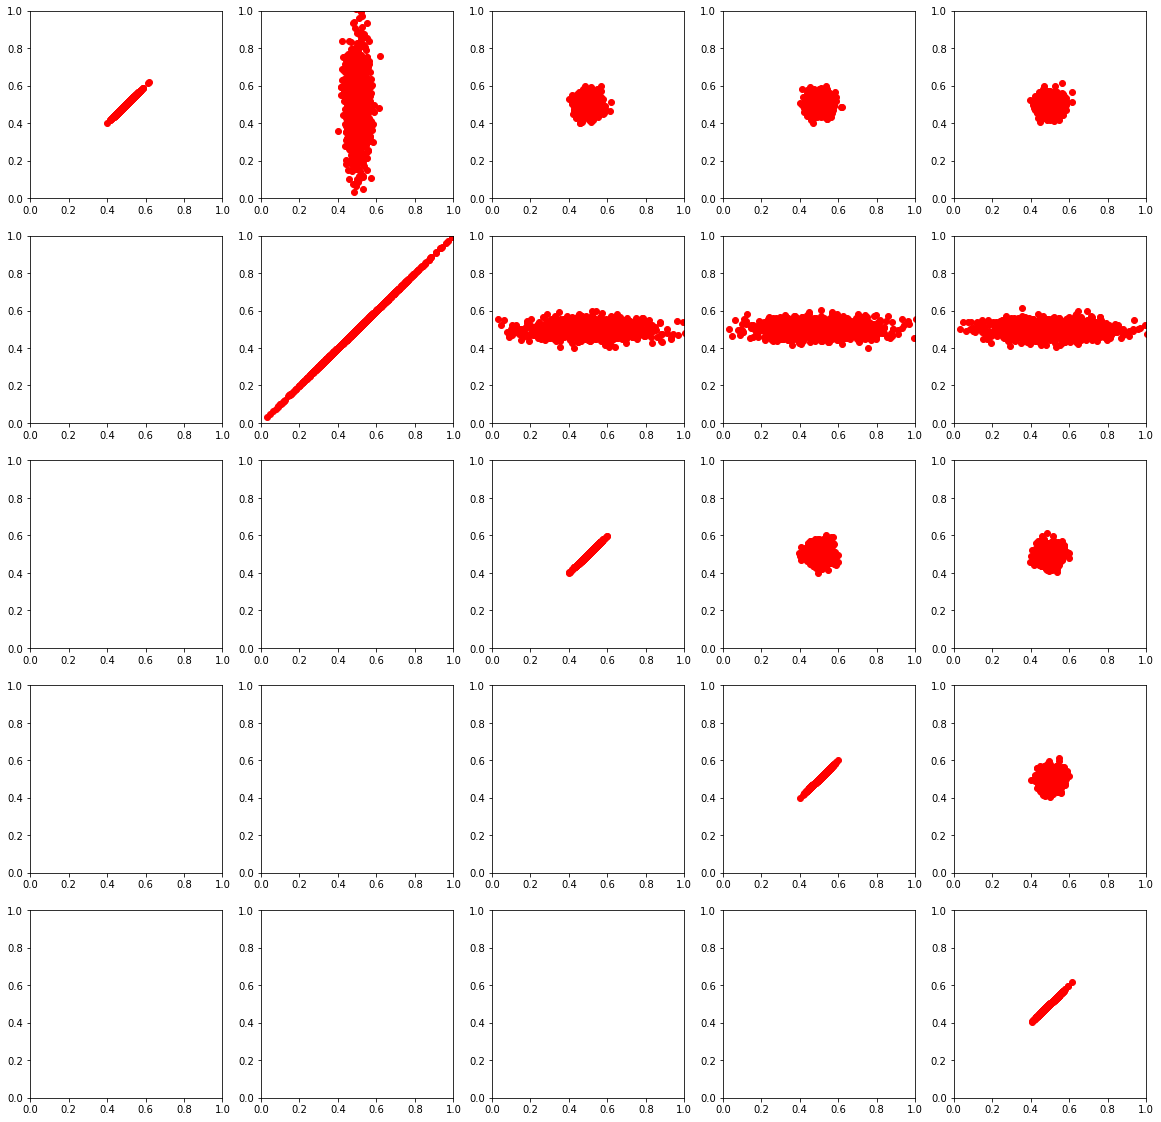

In [199]:
D = np.array([[1,0,0,0,0],
              [0,1,0,0,0],
              [0,0,1,0,0],
              [0,0,0,1,0],
              [0,0,0,0,1]])
C = 1e-2*D.dot(E.dot(D.T))
X_test = multivariate_normal(np.array([0.5,0.5,0.5,0.5,0.5]), C).rvs(1000)
fig, ax = plt.subplots(5,5, figsize=(20,20))
for i in range(p):
    for j in range(i, p):
        ax[i][j].set_xlim([0,1])
        ax[i][j].set_ylim([0,1])        
        ax[i][j].scatter(X_test[:,i], X_test[:,j], color='r')
fig.show()


In [21]:
from pypmc.density.mixture import create_gaussian_mixture


In [11]:
gg = BasicGen(3)
means, covar = gg.get_params()

In [19]:
create_gaussian_mixture(means, covar, 1./4*np.ones(4))

In [135]:
from simu_clustering import simu

# Analyse resultats clustering

In [220]:
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np

%matplotlib inline

simu_folder = "/Users/mehdi/Downloads/data3"
folder  = simu_folder
#folder = "/Users/mehdi/Downloads/"+simu_folder+"/"
onlyfiles = [f for f in listdir(folder) if (isfile(join(folder, f)) and f.startswith("res_K") and "gof" not in f and "pc" not in f)]
data = []
for f in onlyfiles:
    r = pickle.load(open(simu_folder+"/"+f))
#    r["file"] = f
    data.append(r)
df = pd.DataFrame(data)

In [221]:

def extract_type(row):
    if "l2" in row["Type"]:
        metric = "L2"
    else:
        metric = "KL"
    if "EM" in row["Type"]:
        method = "EM-BIC"
    elif "MLE" in row["Type"]: 
        method = "MLE"
    elif "Kde" in row["Type"]:
        method = "KDE CV"
    else:
        method = "0"
    return pd.Series({'method': method, "metric": metric})

def remove_method_comp(row):
    comp = row["comp"]
    comp = int(comp.split("_")[1])
    return pd.Series({'comp':comp, "N":row["N"],"weight": row["weight"], "method":row["method"] })


## graphs losses

In [222]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [223]:
def gen_graph_dict_gen_loss(df, p, metric):
    df_temp = df[(df.p==p) & (df.K == 6)]
    df_temp2 = df_temp.drop(['p', 'K', 'EM_time', 'KdeCV_time', 'MLE_time'], axis=1)
    df2 = pd.melt(df_temp2, id_vars=["N"], var_name="Type", value_name="loss")
    #set(df2["Type"])
    #df3 = pd.melt(df2, id_vars=["N"], var_name="comp", value_name="weight")
    df3 = pd.concat([df2, df2.apply(extract_type, axis =1)], axis=1)
    #df5 = df4.apply(remove_method_comp, axis=1)
    df4 = df3.replace([np.inf, -np.inf], np.nan).dropna(subset=["loss"], how="all")
    plt.figure(figsize=(10,5))
    boxplot = sns.boxplot(x="method", y="loss", data=df4[df4["metric"]==metric], hue="N",
                         palette=["#ff6666", "#ffd966", "#b3ff66"])
    for patch in boxplot.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 1))
    boxplot.set_yscale("log")
    if metric == 'L2':
        boxplot.set_ylabel(r'$L_2$-Loss')
    else:
        boxplot.set_ylabel(metric+'-Loss')
    boxplot.set_xlabel('')

    sns_plot = boxplot.get_figure()
    #_gof_pc_select
    plt.savefig("../../phd-thesis/TeX_files/dict_gen_loss_dim_"+str(p)+"_"+str(metric), dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

In [225]:
def gen_graph_dict_gen_time(df, p):
    df_temp = df[(df.p==p) & (df.K == 6)]
    df_temp.keys()
    df_temp2 = df_temp[['N', 'EM_time', 'KdeCV_time', 'MLE_time']]
    df2 = pd.melt(df_temp2, id_vars=["N"], var_name="Type", value_name="time")
    df3 = pd.concat([df2, df2.apply(extract_type, axis =1)], axis=1)
    plt.figure(figsize=(10,5))
    boxplot = sns.boxplot(x="method", y="time", data=df3, hue="N",
                             palette=["#ff6666", "#ffd966", "#b3ff66"])
    for patch in boxplot.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 1))
    boxplot.set_yscale("log")
    boxplot.set_ylabel("log of time in s")
    boxplot.set_xlabel('')

    sns_plot = boxplot.get_figure()
    plt.savefig("../../phd-thesis/TeX_files/dict_gen_time_dim_"+str(p), dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

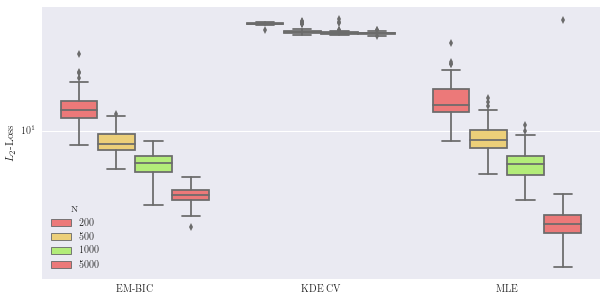

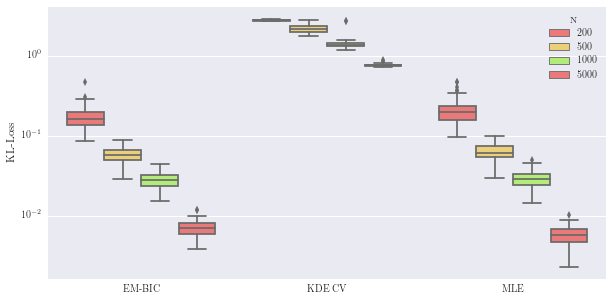

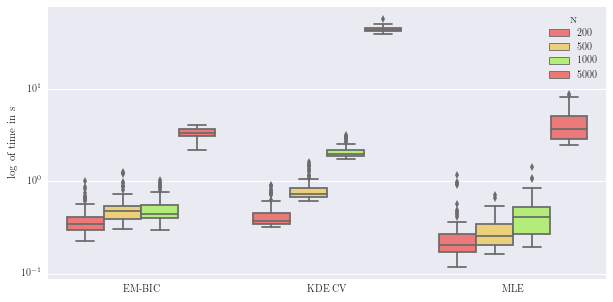

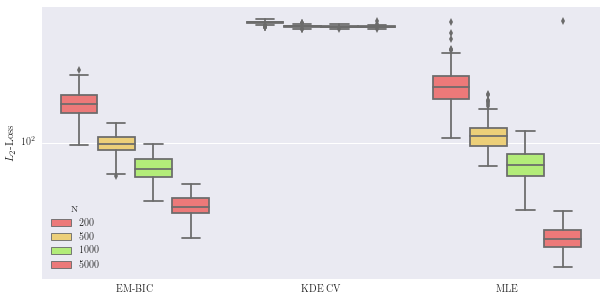

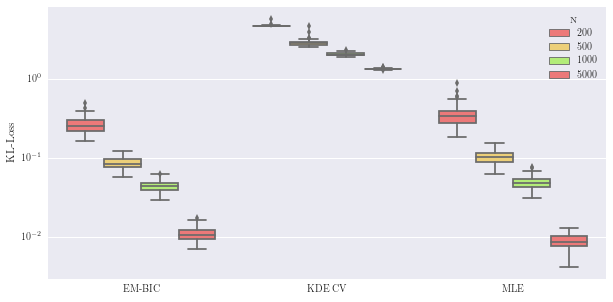

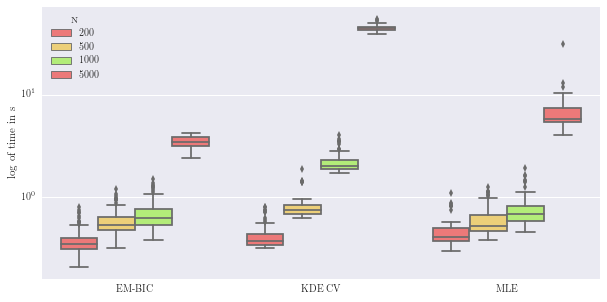

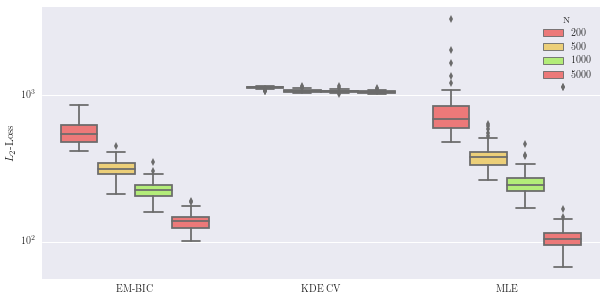

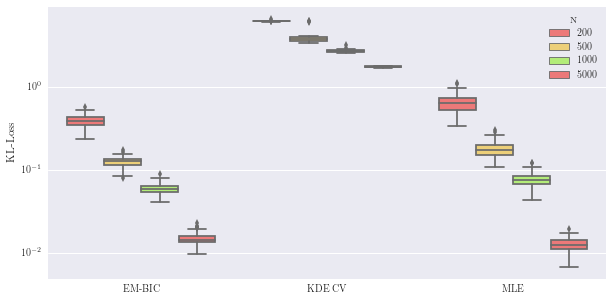

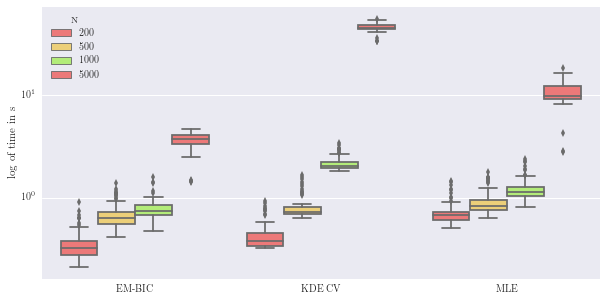

In [226]:
for p in [3,4,5]:
    gen_graph_dict_gen_loss(df, p, "L2")
    gen_graph_dict_gen_loss(df, p, "KL")
    gen_graph_dict_gen_time(df, p)

In [207]:
df[df.p==5][df.N==5000].MLE_KL

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


533    0.224325
534    0.211625
535    0.012778
536    0.017617
537    0.220913
538    0.268559
539    0.271354
540    0.266373
541    0.214393
542    0.297988
543    0.018554
544    0.018287
545    0.011245
546    0.278682
547    0.011589
548    0.270606
549    0.217642
550    0.305561
551    0.258705
552    0.014950
553    0.269582
554    0.218093
555    0.329023
556    0.267896
557    0.021987
558    0.326930
559    0.269046
560    0.237745
561    0.227310
562    0.061809
563    0.011406
564    0.273282
565    0.266353
566    0.012843
567    0.528817
568    0.526770
569    0.270607
570    0.215787
571    0.212573
572    0.406279
573    0.580962
574    0.211981
575    0.210719
576    0.211990
577    0.484867
578    0.222310
579    0.329628
580    0.012130
581    0.218571
582    0.301615
583    0.263860
Name: MLE_KL, dtype: float64